# Sixt Data Science Lab - Test Task for Data Scientist Job Candidates

## Introduction

In this test task you will have an opportunity to demonstrate your skills of a Data Scientist from various angles - processing data, analyzing and vizalizing it, finding insights, applying predictive techniques and explaining your reasoning about it.

The task is based around a bike sharing dataset openly available at UCI Machine Learning Repository [1].

Please go through the steps below, build up the necessary code and comment on your choices.

## Part 1 - Data Loading and Environment Preparation

**Tasks:**
1. Prepare a Python 3 virtual environment (with virtualenv command). requirements.txt output of pip freeze command should be included as part of your submission.
2. Load the data from UCI Repository and put it into the same folder with the notebook. The link to it is https://archive.ics.uci.edu/ml/datasets/bike+sharing+dataset .
3. Load the data into Python runtime as Pandas dataframe.
4. Split the data into two parts. One dataset containing the last 30 days and one dataset with the rest. You will need the dataset with the last 30 days in part 5  

- Virtual anvironment was created from bash as follows:  
```
mkdir <project_directory>
cd <project_directory>
mkdir data
cd data
mkdir input
cd ..
mkdir model
python3 -m venv env
source env/bin/activate
pip install ipykernel
python -m ipykernel install --name=myenv
pip install numpy pandas scikit-learn matplotlib dataprep
```

- Copy notebook in `<project_directory>`
- Put zipped data in `data\input` folder. Unzip it, which will create one more folder `Bike-Sharing-Dataset` in it
- Launch Jupyter Notebook: `jupyter notebook`
- Open the copied notebook, and select the "env" kernel

Let's just confirm our environment:

In [1]:
!which python

/Users/Sahil_Maheshwari-MUM/my_projects/sixt_assignment/env/bin/python


Load the utility functions, which will be used in the notebook below

In [2]:
%run utils.py

### Import Libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import sweetviz as sv
import seaborn as sns
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.express as px
import cufflinks as cf
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import statsmodels.api as sm 
import scipy.stats as stats
import pylab
import functools
import pickle
import joblib

### Setting global options

In [4]:
sns.set(style="whitegrid")
sns.set(rc={'figure.figsize':(11, 4)})
init_notebook_mode(connected=True)
cf.go_offline()

### Load data

Since, we have to predict at day level, we will be reading the day level data

In [5]:
odata_day = pd.read_csv("data/input/Bike-Sharing-Dataset/day.csv")

In [6]:
odata_day.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [7]:
odata_day.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     731 non-null    int64  
 1   dteday      731 non-null    object 
 2   season      731 non-null    int64  
 3   yr          731 non-null    int64  
 4   mnth        731 non-null    int64  
 5   holiday     731 non-null    int64  
 6   weekday     731 non-null    int64  
 7   workingday  731 non-null    int64  
 8   weathersit  731 non-null    int64  
 9   temp        731 non-null    float64
 10  atemp       731 non-null    float64
 11  hum         731 non-null    float64
 12  windspeed   731 non-null    float64
 13  casual      731 non-null    int64  
 14  registered  731 non-null    int64  
 15  cnt         731 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.5+ KB


### Basic data prep.

In [8]:
data_day = odata_day.copy()

In [9]:
data_day['date'] = pd.to_datetime(data_day['dteday']).dt.floor('d')
data_day.drop(columns='dteday', inplace=True)
data_day = data_day.set_index('date')

cat_column_names = ["season", "yr", "mnth", "holiday", "weekday", "workingday", "weathersit"]
cont_column_names = ["temp", "atemp", "hum", "windspeed"]

data_day.loc[:, cat_column_names] = data_day.loc[:, cat_column_names].astype("category") 

In [10]:
data_day.info()
data_day.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 731 entries, 2011-01-01 to 2012-12-31
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   instant     731 non-null    int64   
 1   season      731 non-null    category
 2   yr          731 non-null    category
 3   mnth        731 non-null    category
 4   holiday     731 non-null    category
 5   weekday     731 non-null    category
 6   workingday  731 non-null    category
 7   weathersit  731 non-null    category
 8   temp        731 non-null    float64 
 9   atemp       731 non-null    float64 
 10  hum         731 non-null    float64 
 11  windspeed   731 non-null    float64 
 12  casual      731 non-null    int64   
 13  registered  731 non-null    int64   
 14  cnt         731 non-null    int64   
dtypes: category(7), float64(4), int64(4)
memory usage: 57.7 KB


,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
date,,,,,,,,,,,,,,,
2011-01-01,1,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
2011-01-02,2,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2011-01-03,3,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
2011-01-04,4,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
2011-01-05,5,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


### Taking out last 30 days data

In [11]:
data_beforeLast30Days = data_day.loc['2011-01-01':'2012-11-30']
data_last_30_days = data_day.loc['2012-12-01':'2012-12-31']

print("Shape of training data: ", data_beforeLast30Days.shape)
print("Shape of test data: ", data_last_30_days.shape)

Shape of training data:  (700, 15)
Shape of test data:  (31, 15)


## Part 2 - Data Processing and Analysis

**Tasks:**
1. Perform all needed steps to load and clean the data. Please comment the major steps of your code.
2. Visualise rentals of bikes per day.
3. Assume that each bike has exactly maximum 12 rentals per day.
    * Find the maximum number of bicycles `nmax` that was needed in any one day.
    * Find the 95%-percentile of bicycles `n95` that was needed in any one day.
5. Vizalize the distribution of the covered days depending on the number of available bicycles (e.g. `nmax` bicycles would cover 100% of days, `n95` covers 95%, etc.)


### Time Series Analysis

In [12]:
print(data_beforeLast30Days.index.min())
print(data_beforeLast30Days.index.max())

2011-01-01 00:00:00
2012-11-30 00:00:00


In [13]:
data_beforeLast30Days['cnt'].iplot()

By zooming in, we can observe that  
> **there are weekly, monthly, and yearly patterns**

### No. of cycles needed each day

In [14]:
max_ride_per_bike_per_day = 12

# Let bikes_required_each_day_as_per_the_total_demand be 'n'
data_beforeLast30Days['n'] = np.ceil(data_beforeLast30Days['cnt']/max_ride_per_bike_per_day)

nmax = np.max(data_beforeLast30Days['n'])
n95 = np.quantile(data_beforeLast30Days['n'], 0.95)

print("nmax: ", nmax, ", n95: ", n95)

nmax:  727.0 , n95:  632.05


> So max. no. of bikes required to cover all the demand each day is **727**, and that to cover 95% of the days is **632**

<AxesSubplot:xlabel='n'>

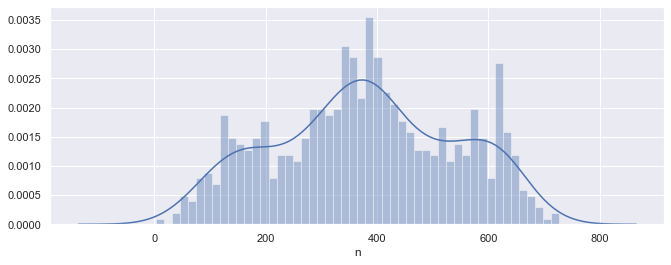

In [15]:
sns.distplot(data_beforeLast30Days['n'], bins=50)

Distribution of covered days is as follows:

In [16]:
n_available_array = np.arange(np.min(data_beforeLast30Days['n']), nmax+1 , 1)

def get_coverage(n_available):
    covered_prop_per_day = (n_available * 12)/data_beforeLast30Days['cnt']
    is_covered_per_day = np.where(covered_prop_per_day < 1, 0, 1)
    covered_days = np.sum(is_covered_per_day)
    covered_ratio = covered_days/data_beforeLast30Days.shape[0]
    return covered_ratio
    
get_coverage_v = np.vectorize(get_coverage)

coverage_ratio_array = get_coverage_v(n_available_array)

df_coverage = pd.DataFrame({'n_available': n_available_array, 'coverage_ratio': coverage_ratio_array})

px.line(df_coverage, x='n_available', y='coverage_ratio')

### Quick initial EDA using 'sweetviz'

We will be using the awesome 'sweetviz' package to generate a quick initial EDA report.  The report gives us two things: 
- univariate plots 
- association plot, which is like a correlaation matrix plot, but also calculates associations between categorical-numeric and categorical-categorical pairs

In [17]:
my_report = sv.analyze(data_beforeLast30Days, "cnt", sv.FeatureConfig(skip="instant"))
my_report.show_html("initial_eda.html")

:FEATURES DONE:                    |█████████████████████| [100%]   00:06  -> (00:00 left)
:PAIRWISE DONE:                    |█████████████████████| [100%]   00:00  -> (00:00 left)


Creating Associations graph... DONE!
Report initial_eda.html was generated! NOTEBOOK/COLAB USERS: no browser will pop up, the report is saved in your notebook/colab files.


Quick Insights from Univariate plots:
- No missing values
- All categorical features have manageable cardinality, so no work requird their too
- Outliers: not as such, but some skewed values:
    - on lower side of humidity (less than .2)
    - on higher side of windspeed (more than .4)
    - Let's explore them more later
- **Total demand and registered demand are approximately normally distributed, but casual demand is highly right skewed. So, we can explore modeling 'registered' and 'casual' demand separately**

Quick Insights from Association Plot:
- These predictors (in row-wise decreasing order) shows noticeable associaton with the total demand
    - year, season, month, temperature
    - weather
    - windspeed (inverse)
- Weekday, working day have high association with casual demand, as compared to registered demand: one more argument in favour of modeling 'registered' and 'casual' demand separately
- Season/month have very high association with temperature, but not with humidity or windspeed
- humidity and wind speed are slightly inversely correlated - no surprise
- temp and atemp are highly correlated - no surprise

### Target vs Predictor

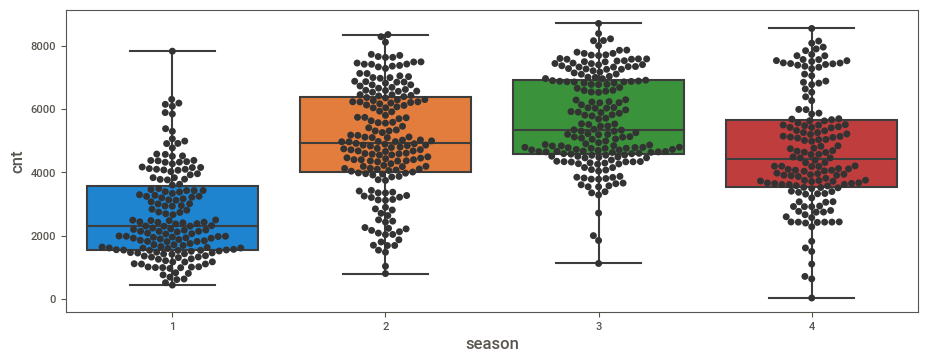

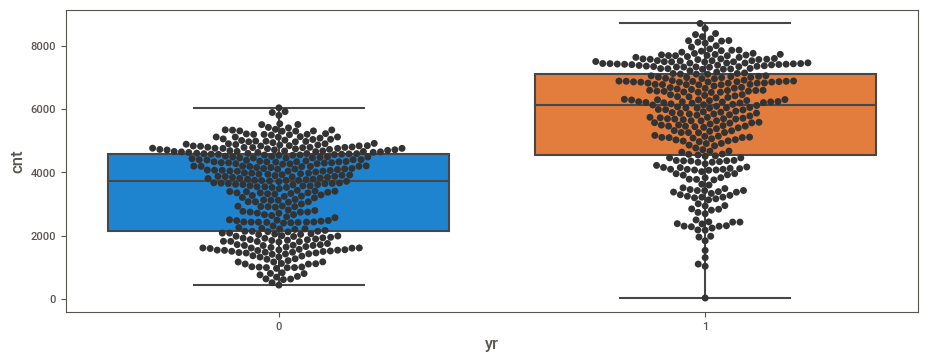

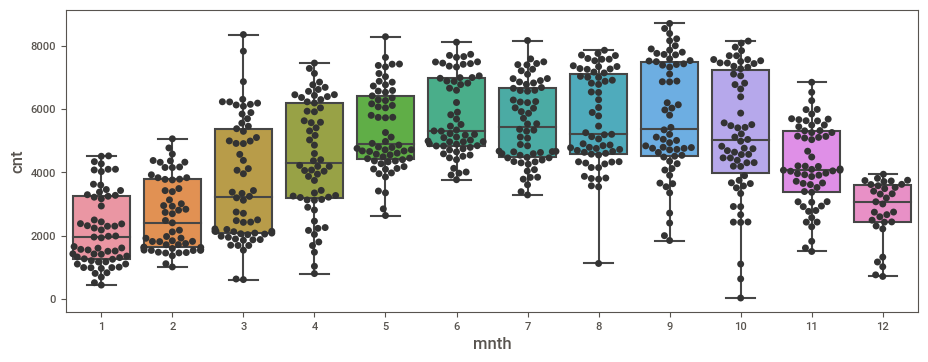

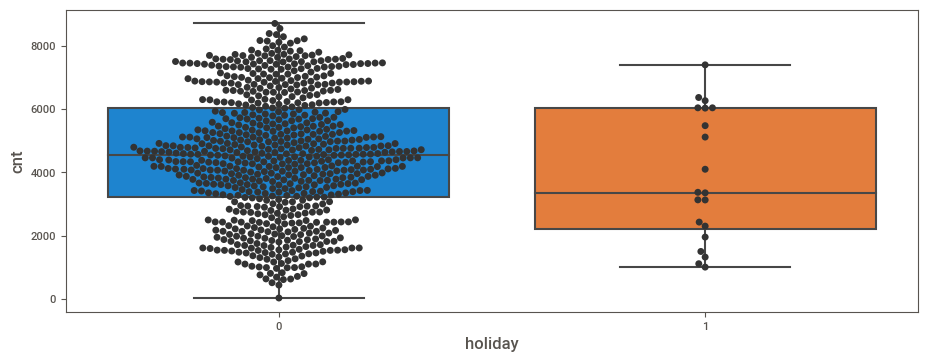

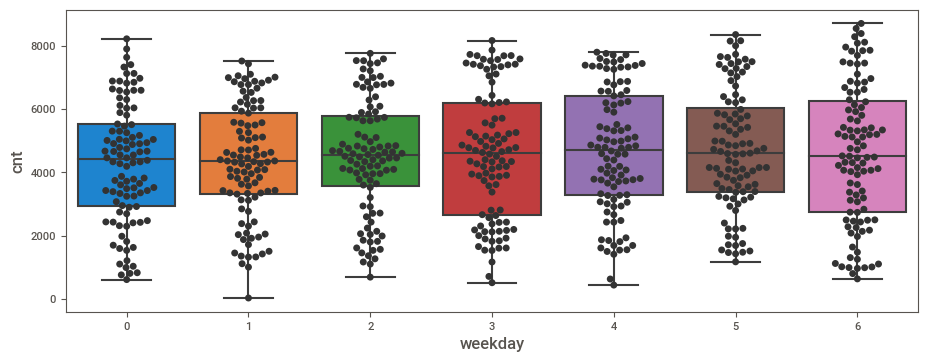

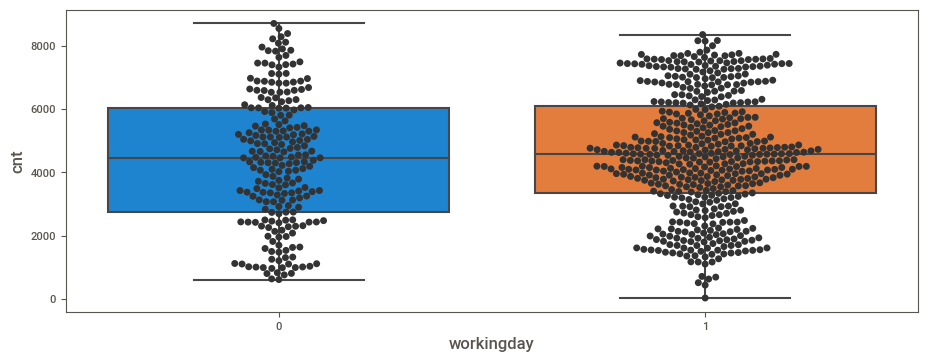

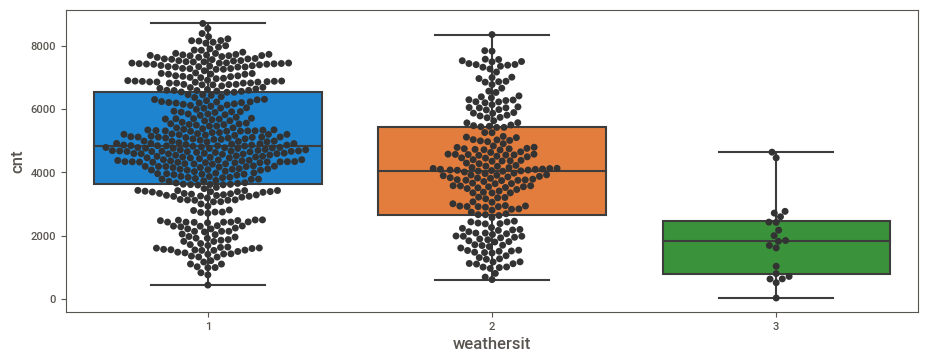

In [18]:
for cat_var in cat_column_names:
    plt.figure()
    ax = sns.boxplot(x=cat_var, y="cnt", data=data_beforeLast30Days, whis=np.inf)
    ax = sns.swarmplot(x=cat_var, y="cnt", data=data_beforeLast30Days, color=".2")
    plt.show()
    

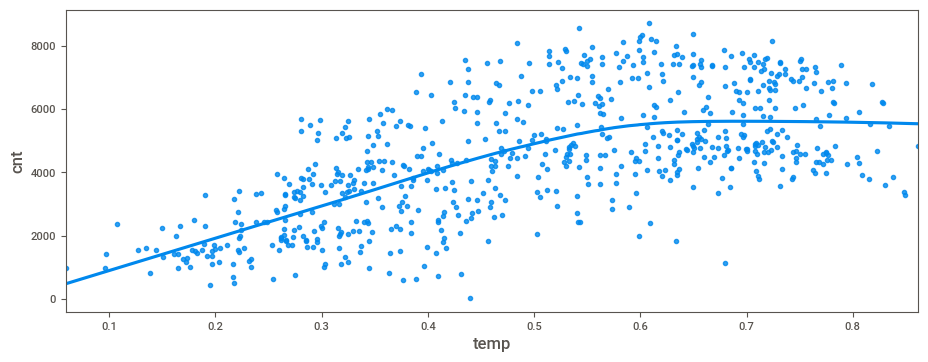

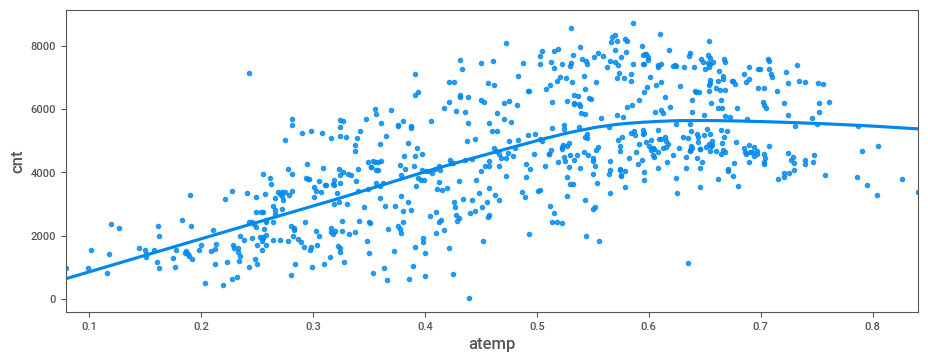

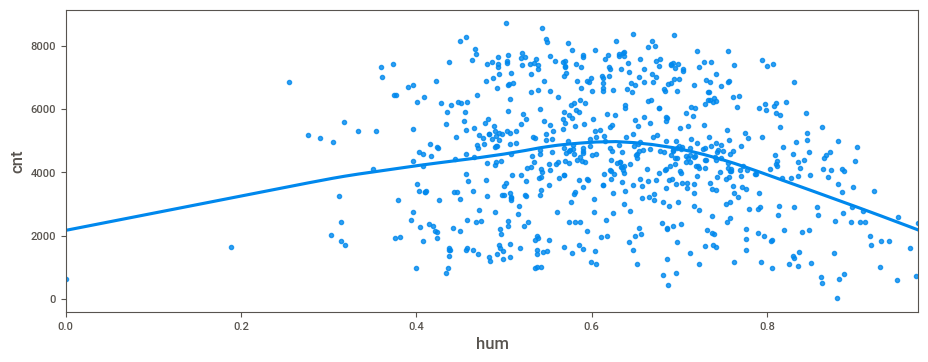

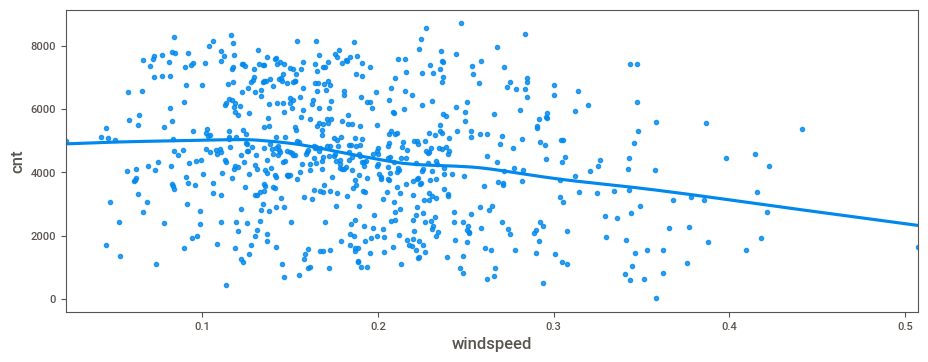

In [19]:
for cont_var in cont_column_names:
    plt.figure()
    ax = sns.regplot(x=cont_var, y="cnt", lowess=True, data=data_beforeLast30Days)
    plt.show()

### Casual' vs Registered

We have got some hints in our EDA till now that 'registered' and 'casual' demand have different patterns. Let's explore this in more detail.

In [20]:
data_beforeLast30Days[['cnt', 'casual', 'registered']].iplot()

I expect 'registered' to be more stable than 'casual', but difference in variance is not clear from the above plot. Let's do a different plot:

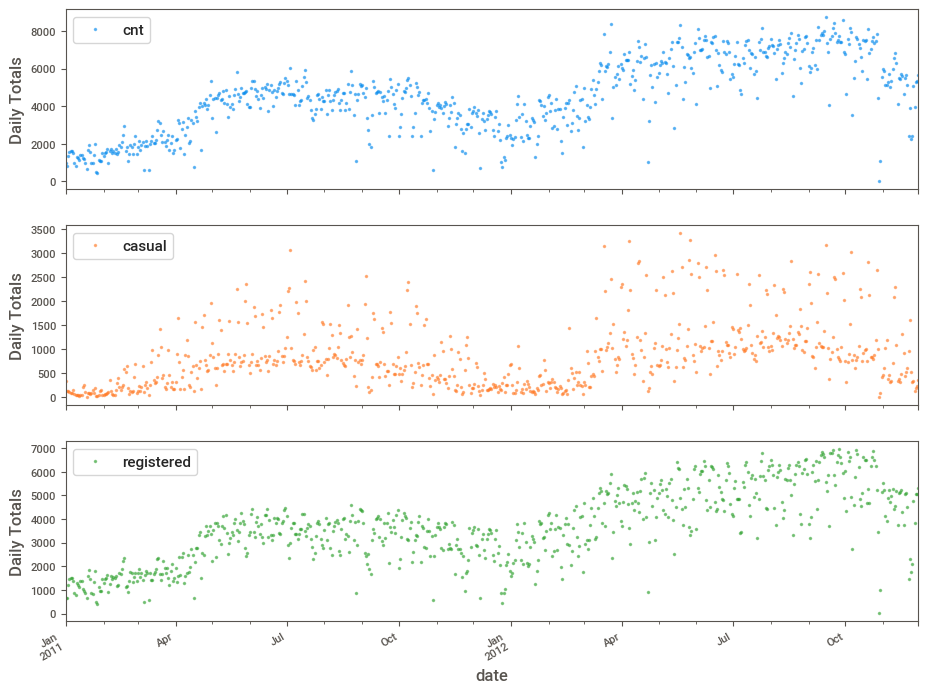

In [21]:
axes = data_beforeLast30Days[['cnt', 'casual', 'registered']].plot(marker='.', alpha=0.5, linestyle='None', figsize=(11, 9), subplots=True)
for ax in axes:
    ax.set_ylabel('Daily Totals')

- As expected, 'casual' has a stable component, and high variance across it, as compared to that of 'registered'
- As observed earlier too, 'registered' demand has an increasing trend from 2011 to 2012. 'Casual' demand does not have this increasing trend, and that's why their difference increases from 2011 t 2012

> Based on these insights, may we can model 'casual and 'registered' separately, and then add up the predictions to get the total demand. Before finalising this strategy, we see how 'casual' and 'registerd' vary w.r.t prdictors, but instead I will just compare the modeling results of 'total' vs 'registered'+'casual' strategies, just that feaure selection has to be separate for both the strategies.

### Outlier Handling

As per the EDA. humidity and windspeed have extrem values. Let's see how observations with these extreme values look like? 

In [22]:
data_beforeLast30Days.query("hum <= .2 | windspeed >= .4").loc[:,'season':'cnt']

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
date,,,,,,,,,,,,,,
2011-02-14,1,0,2,0,1,1,1,0.415000,0.398350,0.375833,0.417908,208,1705,1913
2011-02-19,1,0,2,0,6,0,1,0.399167,0.391404,0.187917,0.507463,532,1103,1635
2011-03-10,1,0,3,0,4,1,3,0.389091,0.385668,0.000000,0.261877,46,577,623
2011-10-20,4,0,10,0,4,1,1,0.475833,0.466525,0.636250,0.422275,471,3724,4195
2012-01-18,1,1,1,0,3,1,1,0.303333,0.275254,0.443333,0.415429,109,3267,3376
2012-02-12,1,1,2,0,0,0,1,0.127500,0.101658,0.464583,0.409212,73,1456,1529
2012-02-25,1,1,2,0,6,0,1,0.290833,0.255675,0.395833,0.421642,317,2415,2732
2012-03-08,1,1,3,0,4,1,1,0.527500,0.524604,0.567500,0.441563,486,4896,5382
2012-03-09,1,1,3,0,5,1,2,0.410833,0.397083,0.407083,0.414800,447,4122,4569


Let's explore this visually via parallel_coordinates plot:

In [23]:
data_beforeLast30Days['mnth_normalized'] = data_beforeLast30Days['mnth'].astype('int64')/data_beforeLast30Days['mnth'].nunique()
data_beforeLast30Days['holiday_normalized'] = data_beforeLast30Days['holiday'].astype('int64')/data_beforeLast30Days['holiday'].nunique()
data_beforeLast30Days['weekday_normalized'] = data_beforeLast30Days['weekday'].astype('int64')/data_beforeLast30Days['weekday'].nunique()
data_beforeLast30Days['weathersit_normalized'] = data_beforeLast30Days['weathersit'].astype('int64')/data_beforeLast30Days['weathersit'].nunique()

px.parallel_coordinates(data_beforeLast30Days.query("hum <= .2 | windspeed >= .4"), color="cnt", dimensions=['mnth_normalized', 'holiday_normalized', 'weekday_normalized', 'weathersit_normalized', 'temp', 'atemp', 'hum', 'windspeed'], color_continuous_scale=px.colors.diverging.Tealrose)

For humidity: There are 2 extreme low values. One has extreme windspeed too, and other is just zero. Let's remove both of them

For windspeed: There are 9 extreme high values and one extreme low (which I would have missed, if not for the humidity). Highest and lowest ones get removed with humidity. The demand for other high values which matches with the pattern - it is either low or high when temperature is high, so I won't remove these rows

None of the above filtering removes any observations from test set, so we need not worry

In [24]:
data_beforeLast30Days_noOutlier = data_beforeLast30Days.query("hum > .2").drop(columns=['mnth_normalized', 'holiday_normalized', 'weekday_normalized', 'weathersit_normalized']).copy()
print("No. of rows removed: ", data_beforeLast30Days.shape[0] - data_beforeLast30Days_noOutlier.shape[0])

No. of rows removed:  2


### Encoding categorical features

As we will be using RandomForest, plus cardinality of all the actegorical features is low, so we will go with One Hot Encoding (OHE) 

In [25]:
cat_binary_column_names = ['yr', 'holiday', 'workingday']
data_beforeLast30Days_noOutlier.loc[:, cat_binary_column_names] = data_beforeLast30Days_noOutlier.loc[:, cat_binary_column_names].astype("uint8") 

columns_to_be_ohe = list(set(cat_column_names) - set(cat_binary_column_names))
data_beforeLast30Days_ohe = pd.get_dummies(data_beforeLast30Days_noOutlier, columns=columns_to_be_ohe)
                              
print(data_beforeLast30Days_ohe.info())                              

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 698 entries, 2011-01-01 to 2012-11-30
Data columns (total 38 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   instant       698 non-null    int64  
 1   yr            698 non-null    uint8  
 2   holiday       698 non-null    uint8  
 3   workingday    698 non-null    uint8  
 4   temp          698 non-null    float64
 5   atemp         698 non-null    float64
 6   hum           698 non-null    float64
 7   windspeed     698 non-null    float64
 8   casual        698 non-null    int64  
 9   registered    698 non-null    int64  
 10  cnt           698 non-null    int64  
 11  n             698 non-null    float64
 12  mnth_1        698 non-null    uint8  
 13  mnth_2        698 non-null    uint8  
 14  mnth_3        698 non-null    uint8  
 15  mnth_4        698 non-null    uint8  
 16  mnth_5        698 non-null    uint8  
 17  mnth_6        698 non-null    uint8  
 18  mnth_7     

### Splitting

This a time series data, though we are not treating it like one, nor we would be applying time series models to it. Still I will keep test set as a single block towards the end instead of cross-validation because its errors will be used for the last 30 days of data, and thus I want the test set to be as near as possible to the last 30 days of data.

*Note: We will not follow this for hyperparameter tuning, there we will use cross validation

In [26]:
data_train = data_beforeLast30Days_ohe.loc['2011-01-01':'2012-10-31']
data_test = data_beforeLast30Days_ohe.loc['2012-11-01':'2012-11-30']

print("Shape of training data: ", data_train.shape)
print("Shape of test data: ", data_test.shape)

Shape of training data:  (668, 38)
Shape of test data:  (30, 38)


### Feature Selection

We have some intuition from the 'Target vs Predictor' analysis on which features are not important, but that was just a single predictor analysis. A predictor which may not seem important, may become important on interaction with some other feature. There are many feature selection algorithms to partly solve this problem, I will be using Boruta with RandomForest.

In [27]:
targets = ['cnt', 'casual', 'registered']
target = 'cnt'
targets_not_considered = list(set(targets) - set([target]))
predictors = list(set(data_train.columns.values) - set(['instant', 'n'] + targets))
print(predictors)

['atemp', 'weekday_1', 'mnth_12', 'mnth_10', 'season_3', 'mnth_4', 'workingday', 'season_4', 'mnth_2', 'mnth_5', 'weekday_4', 'mnth_6', 'mnth_7', 'weekday_5', 'yr', 'mnth_9', 'temp', 'windspeed', 'season_2', 'hum', 'weekday_0', 'weekday_3', 'weathersit_2', 'weekday_6', 'weathersit_1', 'weekday_2', 'mnth_8', 'mnth_3', 'holiday', 'mnth_11', 'mnth_1', 'weathersit_3', 'season_1']


In [28]:
X = data_train.loc[:,predictors].values
y = data_train[target].values.ravel()

rf = RandomForestRegressor(n_jobs=-1)

# define Boruta feature selection method
feat_selector = BorutaPy(rf, n_estimators='auto', verbose=0, random_state=1)

# find all relevant features
feat_selector.fit(X, y)

BorutaPy(estimator=RandomForestRegressor(n_estimators=81, n_jobs=-1,
                                         random_state=RandomState(MT19937) at 0x7F82010C2380),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x7F82010C2380)

In [29]:
# check selected features
selected_columns = data_train.loc[:,predictors].columns.values[feat_selector.support_]

print("Selected columns by Boruta: ", selected_columns)
print("Rejected columns by Boruta: ", data_train.loc[:,predictors].columns.values[~feat_selector.support_])

Selected columns by Boruta:  ['atemp' 'season_4' 'yr' 'temp' 'windspeed' 'hum' 'weathersit_3'
 'season_1']
Rejected columns by Boruta:  ['weekday_1' 'mnth_12' 'mnth_10' 'season_3' 'mnth_4' 'workingday' 'mnth_2'
 'mnth_5' 'weekday_4' 'mnth_6' 'mnth_7' 'weekday_5' 'mnth_9' 'season_2'
 'weekday_0' 'weekday_3' 'weathersit_2' 'weekday_6' 'weathersit_1'
 'weekday_2' 'mnth_8' 'mnth_3' 'holiday' 'mnth_11' 'mnth_1']


To be conservative, we will take a intersectioon of this and EDA i.e. all the columns which  seem not important in EDA, plus ae not important by Boruta will be eliminated

In [30]:
column_to_be_eliminated = ['season_2', 'season_3'] + [i for i in predictors if 'weekday_' in i] + ['holiday', 'workingday']
final_selected_columns = list(set(predictors) - set(column_to_be_eliminated))
final_selected_columns

['atemp',
 'mnth_12',
 'mnth_10',
 'mnth_4',
 'season_4',
 'mnth_2',
 'mnth_5',
 'mnth_6',
 'mnth_7',
 'yr',
 'mnth_9',
 'temp',
 'windspeed',
 'hum',
 'weathersit_2',
 'weathersit_1',
 'mnth_8',
 'mnth_3',
 'mnth_11',
 'mnth_1',
 'weathersit_3',
 'season_1']

## Part 3 - Building prediction models

**Tasks:**
1. Define a test metric for predicting the daily demand for bike sharing, which you would like to use to measure the accuracy of the constructed models, and explain your choice.
2. Build a demand prediction model with Random Forest, preferably making use of following python libraries: scikit-learn. 
3. Report the value of the chosen test metric on the provided data. 

### Evaluation Metric

Let's just see train and test mean before deciding on the the evaluation metric

In [31]:
y_train_mean = data_train.cnt.mean()
y_test_mean = data_test.cnt.mean()

print('train demand mean: ', y_train_mean, ', test demand mean: ', y_test_mean)

train demand mean:  4512.041916167665 , test demand mean:  5088.8


Let's revisit the basics to decide on the evaluation metric
- Sign of errors: Our predicted demand will be used for planning our bike inventory. So, there will be extra cost if the model predicts higher than the actual demand i.e. positive error, and missed revenue if it predicts lower i.e. negative error. **As per the stated problem, there is no favourism between extra cost vs missed revenue, so we will weigh positive and negative errors equally**.

- Magnitude of errors: For this we need to answer the following questions: **"do we want a forecast which is little off at many places, or one which is more off at fewer places?". Squaring favours the former more than the latter compared to Absoluting. I think we need 'a forecast which is little off at many places' because we will be using the higher end of demand forecast for keeping up inventory, so if we have a high positive error and that can really make us keep high inventory. Taking a 90th 0r 95th percentile (depending on how many high erors) we can solve this problem**. Currently am not sure, so for now we will keep both, but based on our optimization results, we may want to revisit this.

- Meand vs Median: This also depends on answering "little off at many places or more off at fewer places?". Mean favours the former and Median the latter. The whole point of Squaring is to penalize higher error more, so ignoring extreme values does not make sense, so with Squaring it should always be Mean. Now, Absoluting does not weigh lower errors more than higher, it weighs them equally, its just that its relative weighing of higher/lower error is less than that of Squaring, so both Mean and Median may make sense depending on how we answer the question.

- Scale/Unit Invariance: A metric should be scale invariant if want to compare two targets at different scales. Here, that's not the case, but scale of train and test vary slightly, so scale invariance can be useful. So, we will have different rSquared metrics, which uses a baseline prediction to build a ratio metric, which can then be compared across different scales. I will use train's mean as the baseline

- Comparison with baseline: It is always good to have a metric which tells improvement with respect to some baseline. So, we would normalize all our metrics with their respective baseline ones

Bsed on these criterion, we will have following metrics: **'RMeanSE', 'MeanAE', 'MedianAE', 'RMeanSE_r2', 'MeanAE_r2', 'MedianAE_r2'**.

**I case of a conflict we will favour 'RMeanSE_r2'**

### Baselining

In [32]:
print(pd.DataFrame(get_eval_metric(data_train.cnt, y_train_mean), index=['train baseline metrics']))
print("\n")
print(pd.DataFrame(get_eval_metric(data_test.cnt, y_train_mean, y_train_mean), index=['test baseline metrics']))


                        RMeanSE   MeanAE  MedianAE  RMeanSE_r2  MeanAE_r2  \
train baseline metrics  1958.86  1601.04    1485.5         0.0        0.0   

                        MedianAE_r2  
train baseline metrics          0.0  


                       RMeanSE   MeanAE  MedianAE  RMeanSE_r2  MeanAE_r2  \
test baseline metrics  1251.56  1108.97    984.96         0.0        0.0   

                       MedianAE_r2  
test baseline metrics          0.0  


Points to note:
- Train mean gives less error on test then on train! funny!  
- All '_r2' are zero because we ae comparing baseline with baseline

### RF Model

In [33]:
X = data_train.loc[:,final_selected_columns].values
y = data_train[target].values.ravel()

X_test = data_test.loc[:,final_selected_columns].values
y_test = data_test[target].values.ravel()

rf_model = RandomForestRegressor(oob_score=True, random_state=123, verbose=0, n_jobs=-1)

rf_model.fit(X, y)

RandomForestRegressor(n_jobs=-1, oob_score=True, random_state=123)

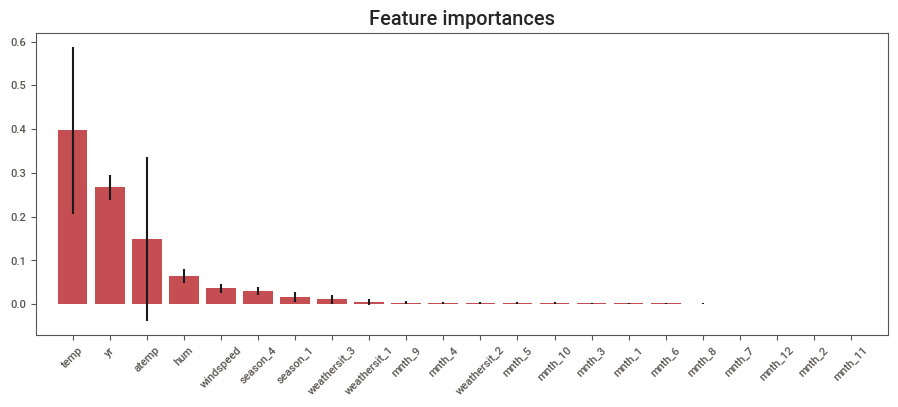

In [34]:
plot_model_importance(rf_model, final_selected_columns)

- 'month' was a suspect earlier too, and this graph confirms that its not that important (at least for RF model)
- 'atemp''s variance goes till zero. I suspect its not that important given 'temp', which is also indicated by their high correlation. Let's try removing this too in the next model

In [35]:
print("OOB score: ", rf_model.oob_score_)

OOB score:  0.8780854694818473


In [36]:
print(pd.DataFrame(get_eval_metric(y, np.round(rf_model.oob_prediction_, 0)), index=['OOB metrics']))

y_pred_train = np.round(rf_model.predict(X), 0)
print(pd.DataFrame(get_eval_metric(y, y_pred_train), index=['train_metrics']))


y_pred_test_rf1 = np.round(rf_model.predict(X_test), 0)

print(pd.DataFrame(get_eval_metric(y_test, y_pred_test_rf1, y_train_mean), index=['test_metrics']))

abs_error_train_rf1 = np.abs(y_pred_train - y)
abs_error_test_rf1 = np.abs(y_pred_test_rf1 - y_test)

             RMeanSE  MeanAE  MedianAE  RMeanSE_r2  MeanAE_r2  MedianAE_r2
OOB metrics   683.98  475.12     341.5      0.6508     0.7032       0.7701
               RMeanSE  MeanAE  MedianAE  RMeanSE_r2  MeanAE_r2  MedianAE_r2
train_metrics   252.38  174.14     123.0      0.8712     0.8912       0.9172
              RMeanSE  MeanAE  MedianAE  RMeanSE_r2  MeanAE_r2  MedianAE_r2
test_metrics  1097.39  973.53     953.0      0.1232     0.1221       0.0324


Train prediction visualisation:

Test error metrics are very high as compared to train error metrics, so the model is overfitting a lot. We will try to solve this by tuning the hyperparameters. 

In [37]:
data_train['cnt_pred'] = y_pred_train
data_train['cnt_pred_oob'] = rf_model.oob_prediction_
data_train[['cnt', 'cnt_pred']].iplot()

Test prediction visualisation:

In [38]:
data_test['cnt_pred'] = y_pred_test_rf1
data_test[['cnt', 'cnt_pred']].iplot()

Train and Test together: for comparison:

In [39]:
data_trainLast_plus_test = data_train[['cnt', 'cnt_pred']].tail(60).append(data_test[['cnt', 'cnt_pred']])

data_trainLast_plus_test.iplot()

Not able to draw a vertical line to mark test start, but it starts at 'Nov-1-2012'. Somehow test predictions are just off from that point!

## Part 4 - Fine-tuning of one of the models

**Tasks:**
1. Take one of the above constructed models and finetune its most important hyperparameters
2. Explain your choice for the hyperparameters
3. Report the improvement of your test metric

### Feature Selection - 2

Let's try removing few featurs which we were not sure about earlier too, but whose unimportnant-ness has been reinforced by the importance plot - all 'month' features and 'atemp'

In [40]:
column_to_be_eliminated_new = column_to_be_eliminated + [i for i in predictors if 'mnth_' in i] + ['atemp']
final_selected_columns_2 = list(set(predictors) - set(column_to_be_eliminated_new))
print(final_selected_columns_2)

X = data_train.loc[:,final_selected_columns_2].values
y = data_train[target].values.ravel()

X_test = data_test.loc[:,final_selected_columns_2].values
y_test = data_test[target].values.ravel()

rf_model_lessFeatures = RandomForestRegressor(oob_score=True, random_state=123, verbose=0, n_jobs=-1)

['temp', 'windspeed', 'hum', 'season_4', 'weathersit_3', 'weathersit_2', 'weathersit_1', 'yr', 'season_1']


In [41]:
rf_model_lessFeatures.fit(X, y)

RandomForestRegressor(n_jobs=-1, oob_score=True, random_state=123)

In [42]:
y_pred_train = np.round(rf_model_lessFeatures.predict(X), 0)
print(pd.DataFrame(get_eval_metric(y, y_pred_train), index=['train_metrics']))


y_pred_test_rf2 = np.round(rf_model_lessFeatures.predict(X_test), 0)
print(pd.DataFrame(get_eval_metric(y_test, y_pred_test_rf2, y_train_mean), index=['test_metrics']))

abs_error_train_rf2 = np.abs(y_pred_train - y)
abs_error_test_rf2 = np.abs(y_pred_test_rf2 - y_test)

               RMeanSE  MeanAE  MedianAE  RMeanSE_r2  MeanAE_r2  MedianAE_r2
train_metrics   258.52  182.22     133.0       0.868     0.8862       0.9105
              RMeanSE  MeanAE  MedianAE  RMeanSE_r2  MeanAE_r2  MedianAE_r2
test_metrics  1054.38  906.43     872.5      0.1575     0.1826       0.1142


Comparison of train's absolute error between models


<AxesSubplot:>

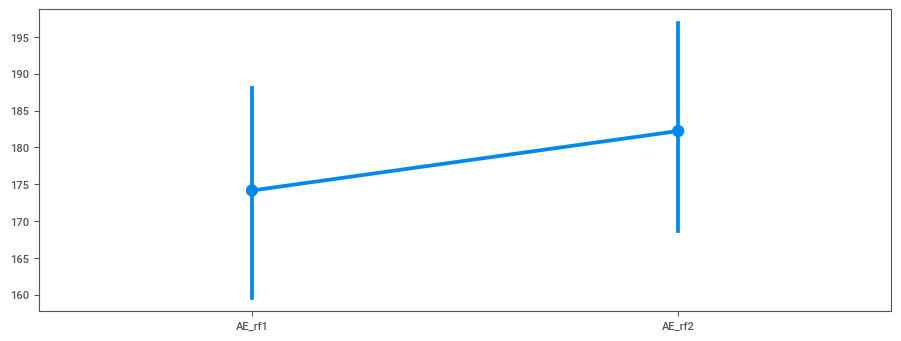

In [43]:
print("Comparison of train's absolute error between models")
sns.pointplot(data = pd.DataFrame({'AE_rf1': abs_error_train_rf1, 'AE_rf2': abs_error_train_rf2}))

Comparison of test's absolute error between models


<AxesSubplot:>

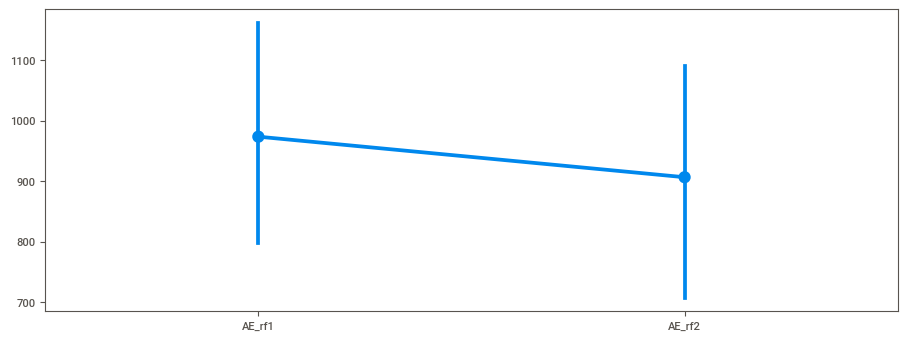

In [44]:
print("Comparison of test's absolute error between models")
sns.pointplot(data = pd.DataFrame({'AE_rf1': abs_error_test_rf1, 'AE_rf2': abs_error_test_rf2}))

Train and Test together: for comparison:

In [45]:
df_train_pred = data_train[['cnt']].copy()
df_train_pred['cnt_pred'] = y_pred_train

df_test_pred = data_test[['cnt']].copy()
df_test_pred['cnt_pred'] = y_pred_test_rf2

df_pred_trainLast_plus_test = df_train_pred[['cnt', 'cnt_pred']].tail(60).append(df_test_pred[['cnt', 'cnt_pred']])

data_trainLast_plus_test.iplot()

Absolute based error metrics improved slightly, Squared based decreased even more slightly. Though, we said that we will favour 'RMeanSE_r2' in  case of conflicts, but the change is very less and in return we have a much simpler model, so we will move ahead with this predictor set only


### Hyperparameter Optimisation

- The model is overfitting, so we should tune those parameters which have a regularization effect

- Plus, the model has high errors on test data, we don't want that, so we will keep 'MSE' as the hyperparameter optimization metric

In [46]:
# final_selected_columns_forTuning = final_selected_columns + ['mnth_4', 'mnth_9', 'mnth_10'] + ['holiday', 'workingday']
final_selected_columns_forTuning = final_selected_columns_2
print(final_selected_columns_forTuning)

X = data_train.loc[:,final_selected_columns_forTuning].values
y = data_train[target].values.ravel()

X_test = data_test.loc[:,final_selected_columns_forTuning].values
y_test = data_test[target].values.ravel()



['temp', 'windspeed', 'hum', 'season_4', 'weathersit_3', 'weathersit_2', 'weathersit_1', 'yr', 'season_1']


In [47]:
param_grid = {
    'bootstrap': [True],
    'max_samples': np.arange(0.7, 1.001, 0.1).tolist(),
    'max_features': np.arange(0.5, 1, 0.1).tolist(),
    'max_depth': np.arange(3 , 8, 1).tolist(),
    'min_samples_leaf': np.arange(0.01, 0.11, 0.01).tolist(),
    'n_estimators': np.arange(100, 300, 50).tolist()
}

rf = RandomForestRegressor(random_state=123)

grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, scoring='neg_mean_squared_error', n_jobs = -1, verbose = 0)


In [48]:
# grid_search.fit(X, y)
# joblib.dump(grid_search, 'model/grid_search.sav')
grid_search = joblib.load('model/grid_search.sav')

In [49]:
grid_search.best_params_


{'bootstrap': True,
 'max_depth': 7,
 'max_features': 0.7999999999999999,
 'max_samples': 0.9999999999999999,
 'min_samples_leaf': 0.01,
 'n_estimators': 100}

In [50]:
best_grid_model = grid_search.best_estimator_


In [51]:
y_pred_train = np.round(best_grid_model.predict(X), 0)
print(pd.DataFrame(get_eval_metric(y, y_pred_train), index=['train_metrics']))

y_pred_test_rfTuned = np.round(best_grid_model.predict(X_test), 0)
print(pd.DataFrame(get_eval_metric(y_test, y_pred_test_rfTuned, y_train_mean), index=['test_metrics']))

abs_error_train_rfTuned = np.abs(y_pred_train - y)
abs_error_test_rfTuned = np.abs(y_pred_test_rfTuned - y_test)

               RMeanSE   MeanAE  MedianAE  RMeanSE_r2  MeanAE_r2  MedianAE_r2
train_metrics  2971.54  2463.22    2023.0      -0.517    -0.5385      -0.3618
              RMeanSE   MeanAE  MedianAE  RMeanSE_r2  MeanAE_r2  MedianAE_r2
test_metrics  2692.46  2319.13    2704.5     -1.1513    -1.0912      -1.7458


Comparison of train's absolute error between models


<AxesSubplot:>

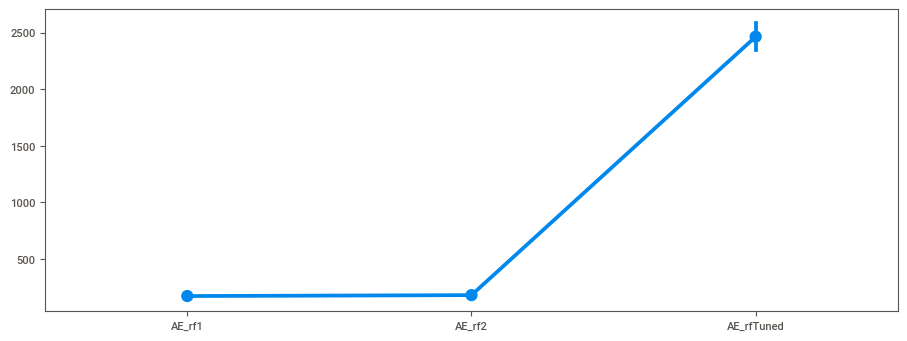

In [52]:
print("Comparison of train's absolute error between models")
sns.pointplot(data = pd.DataFrame({'AE_rf1': abs_error_train_rf1, 'AE_rf2': abs_error_train_rf2, 'AE_rfTuned': abs_error_train_rfTuned}))

Comparison of test's absolute error between models


<AxesSubplot:>

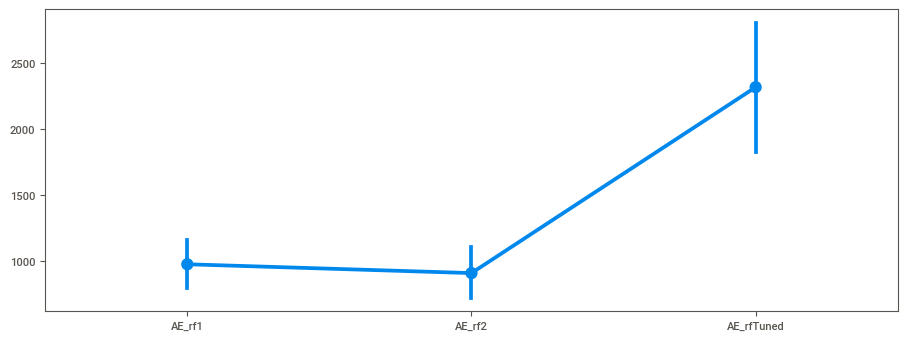

In [53]:
print("Comparison of test's absolute error between models")
sns.pointplot(data = pd.DataFrame({'AE_rf1': abs_error_test_rf1, 'AE_rf2': abs_error_test_rf2, 'AE_rfTuned': abs_error_test_rfTuned}))

Train and Test together: for comparison:

In [54]:
df_train_pred = data_train[['cnt']].copy()
df_train_pred['cnt_pred'] = y_pred_train

df_test_pred = data_test[['cnt']].copy()
df_test_pred['cnt_pred'] = y_pred_test_rfTuned

df_pred_trainLast_plus_test = df_train_pred[['cnt', 'cnt_pred']].tail(60).append(df_test_pred[['cnt', 'cnt_pred']])

data_trainLast_plus_test.iplot()

Comparison of test predictions from different models with the actual:

In [55]:
df_test_pred = data_test[['cnt']].copy()
df_test_pred['cnt_pred_rf1'] = y_pred_test_rf1
df_test_pred['cnt_pred_rf2'] = y_pred_test_rf2
df_test_pred['cnt_pred_rfTuned'] = y_pred_test_rfTuned

df_test_pred.iplot()

In my multiple runs of this with different seeds, training error always increased a lot, and test error sometimes decreased slightly and sometimes decreased. Overall this model is not good.  

**I am very much interested to find out why on tuning the training error is shooting so high up without any benefit on test error, this is very weird, but because of lack of time I will leave the predictive modeling here, and will move to inventory optimization. I will cover what I could have done here, given enough time, in the ending comments.**


### Final Model Selection

In [56]:
final_predictors = final_selected_columns_2
X = data_train.loc[:,final_predictors].values
y = data_train[target].values.ravel()

X_test = data_test.loc[:,final_predictors].values
y_test = data_test[target].values.ravel()

final_model = rf_model_lessFeatures

final_train_pred = np.round(final_model.predict(X), 0)
df_final_train_pred = data_train[['cnt']].copy()
df_final_train_pred['cnt_pred'] = final_train_pred

final_test_pred = np.round(final_model.predict(X_test), 0)
df_final_test_pred = data_test[['cnt']].copy()
df_final_test_pred['cnt_pred'] = final_test_pred

## Part 5 - Optimise (revenue - cost) by adapting number of bicycles
**Tasks:**
1. Assume that the revenue per rental is x (your own assumed number).
2. Each bicycle has costs of y per day (your own assumed number).
3. Determine residuals from your test set (after predicting demand of bike sharing). Consider the residuals as random shocks affecting the average values and resulting in real observed values. Assume this random variable is gaussian distributed. Calculate mean and standard deviation and use it as approximation for a gaussian distribution where you can sample from.
4. Simulate the profit with a fixed number of `nmax` (from part 2) bicycles for the next 30 days given that the real observed values are expected to be different from average predicted values. Calculate the demand by adding the simulated residuals to calculated expected values from the data you put aside in part 1.
5. Use grid search along the number of available bikes to find the optimal number of bikes to obtain highest profit (revenue - cost) from simulations.


### Predict demand on last 30 days data

In [57]:
data_last_30_days.loc[:, cat_binary_column_names] = data_last_30_days.loc[:, cat_binary_column_names].astype("uint8") 

data_last_30_days_ohe = pd.get_dummies(data_last_30_days, columns=columns_to_be_ohe)

X_last30 = data_last_30_days_ohe.loc[:,final_predictors].values
y_last30 = data_last_30_days_ohe[target].values.ravel()

final_last30_pred = np.round(final_model.predict(X_last30), 0)

df_final_last30_pred = data_last_30_days[[target]].copy()
df_final_last30_pred['cnt_pred'] = final_last30_pred

### Test vs Last 30 Days

Before going further, let's compare test and last 30 days data and predictions.

> **Note: I understand that in real life we won't have the data on future (which last 30 days is a proxy for here), so we won't have the luxury to compare. Am just doing it for analysis purpose.**

#### Actual

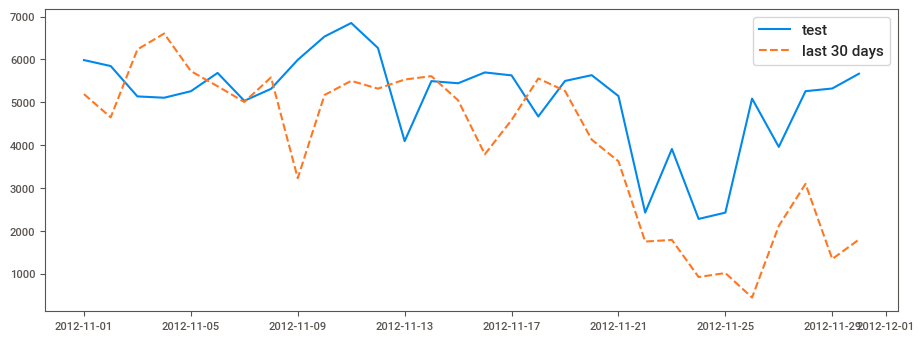

In [58]:
data_last_30_days_woIndex = data_last_30_days.reset_index(drop = True).drop(index=30)
fig, ax = plt.subplots()
ax.plot(data_test.index, data_test[target], '-', label='test')
ax.plot(data_test.index, data_last_30_days_woIndex[target], '--', label='last 30 days')
ax.legend()
plt.show()

#### Predicted

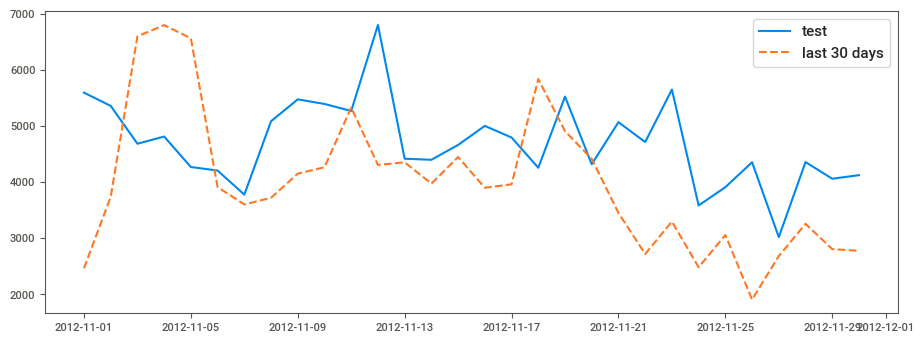

In [59]:
df_final_last30_pred_woIndex = df_final_last30_pred.reset_index(drop = True).drop(index=30)
fig, ax = plt.subplots()
ax.plot(df_final_test_pred.index, df_final_test_pred['cnt_pred'], '-', label='test')
ax.plot(df_final_test_pred.index, df_final_last30_pred_woIndex['cnt_pred'], '--', label='last 30 days')
ax.legend()
plt.show()

#### Errors

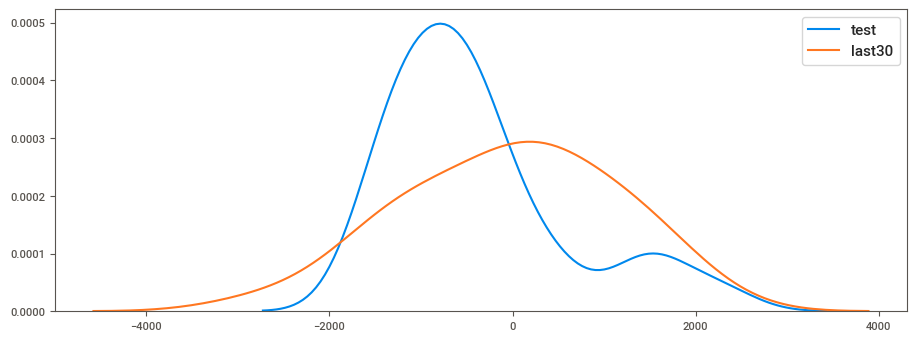

In [60]:
test_error = final_test_pred - y_test
last30_error = final_last30_pred - y_last30

sns.kdeplot(test_error, label="test")
sns.kdeplot(last30_error, label="last30")
plt.legend()

> So, the distribution of error is quite different. So, its not a good idea to use test errors to simulate last 30 days error, but in real life we will NOT know this, so I will go ahead.

### Approximating a normal distribution from Test errors

In [61]:
test_error = final_test_pred - y_test
print("Quantiles:\n", np.quantile(test_error, np.arange(0,1.0001,0.1)))
test_error_mean = np.mean(test_error)
test_error_sd = np.std(test_error)
print('\ntest error mean: ', test_error_mean, ', test error sd: ', test_error_sd)

Quantiles:
 [-1588.  -1335.5 -1170.   -959.   -806.8  -610.5  -441.6  -279.5    80.6
  1320.9  2285. ]

test error mean:  -394.96666666666664 , test error sd:  977.6066176580889


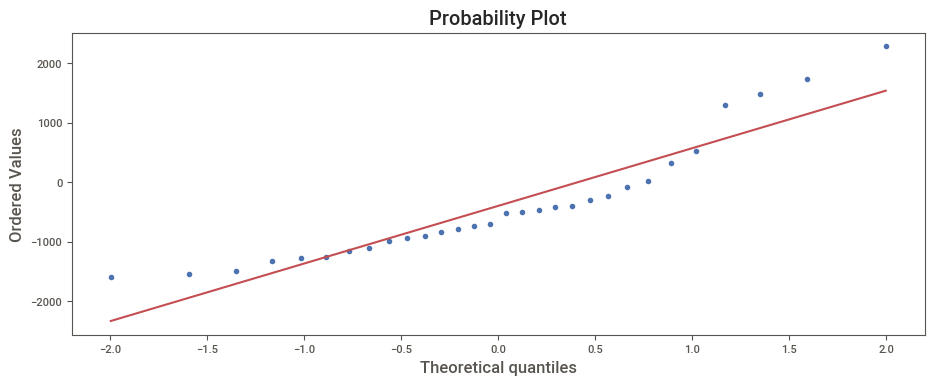

In [62]:
stats.probplot(test_error, dist="norm", plot=pylab)
pylab.show()


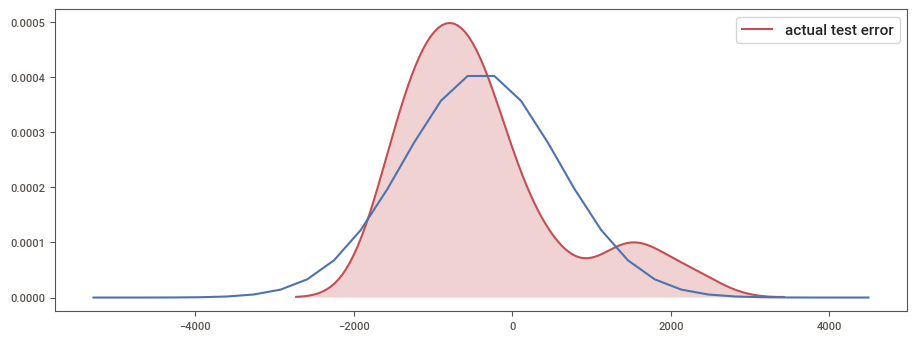

In [63]:
ax = sns.kdeplot(test_error, shade=True, color="r", label="actual test error")
x = np.linspace(test_error_mean - 5*test_error_sd, test_error_mean + 5*test_error_sd, test_error.shape[0])
ax.plot(x, stats.norm.pdf(x, test_error_mean, test_error_sd), color="b", label="simulated error")
plt.show()

> Test errors are NOT normally distributed (but they are not veryy far away from it). Building a normal distribution from them is not a good idea. But for now, I will go with it because that's the ask.

### Simulate the profit with a fixed number of nmax

Let's assume values for 'revenue_per_rental' and 'cost_per_bike_per_day'

In [64]:
def convert_predicted_demand_to_realLike(seed, demand_predicted, test_error_mean, test_error_sd):
    np.random.seed(seed)
    random_errors = np.random.normal(test_error_mean, test_error_sd, demand_predicted.shape[0])
    return np.add(demand_predicted, random_errors)

def get_revenue(nmax, revenue_per_rental, per_day_demand):
    return np.sum(revenue_per_rental * np.minimum(nmax * max_ride_per_bike_per_day, per_day_demand))
    
def get_cost(nmax, cost_per_bike_per_day, per_day_demand):
    return cost_per_bike_per_day * nmax * per_day_demand.shape[0]

def get_profit(nmax, revenue_per_rental, cost_per_bike_per_day, per_day_demand):
    revenue = get_revenue(nmax, revenue_per_rental, per_day_demand)
    cost = get_cost(nmax, cost_per_bike_per_day, per_day_demand)
    return np.array([revenue, cost, revenue - cost])    

In [65]:
revenue_per_rental = 1
cost_per_bike_per_day = 5
no_of_simulations = 100

Distrbution of predicted day wise demand after adding simulated test error to it:

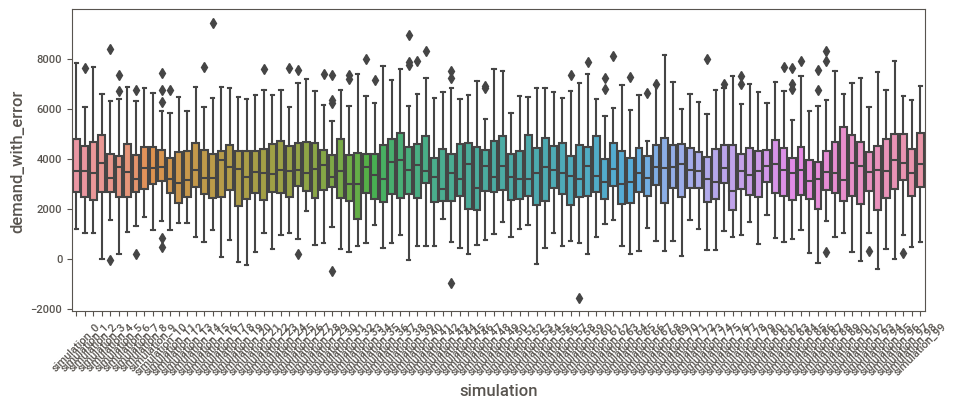

In [66]:
np.random.seed(123)
seed_array = np.random.randint(10000, size=no_of_simulations)

per_day_demand_withError_array = np.array(list(map(functools.partial(convert_predicted_demand_to_realLike, demand_predicted=final_last30_pred, test_error_mean=test_error_mean, test_error_sd=test_error_sd), seed_array)))

per_day_demand_withError_array_t = per_day_demand_withError_array.transpose()
simulation_col_names = np.char.add('simulation_', np.arange(no_of_simulations).astype('str'))
per_day_demand_withError_df = pd.DataFrame(data = per_day_demand_withError_array_t, index=range(data_last_30_days.shape[0]), columns=simulation_col_names)
per_day_demand_withError_df.index.name = 'day'
per_day_demand_withError_df.reset_index(inplace=True)
per_day_demand_withError_melted = pd.melt(per_day_demand_withError_df, value_vars=simulation_col_names, value_name='demand_with_error', var_name='simulation')

ax = sns.boxplot(x="simulation", y="demand_with_error", data=per_day_demand_withError_melted)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.show()

As can be seen, there is some variation across simulations

In [67]:
sim_array = np.zeros((no_of_simulations, 3))


for j in range(no_of_simulations):
    sim_array[j,:] = get_profit(nmax=nmax, revenue_per_rental=revenue_per_rental, cost_per_bike_per_day=cost_per_bike_per_day, per_day_demand=per_day_demand_withError_array[j,:])

sim_df = pd.DataFrame(data = sim_array, columns=['revenue', 'cost', 'profit'], index=range(no_of_simulations))
sim_df.index.name = 'simulation'
sim_df.reset_index(inplace=True)

<AxesSubplot:xlabel='profit'>

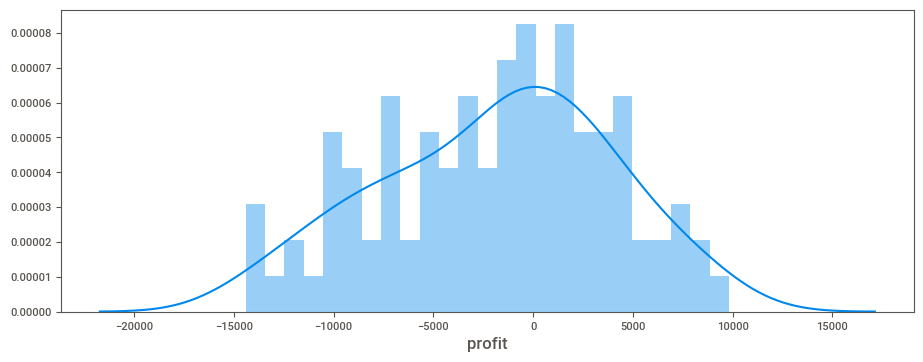

In [68]:
sns.distplot(sim_df['profit'], bins=25)

In [69]:
print("Mean Profit at nmax=", nmax, " is ", sim_df['profit'].mean())

Mean Profit at nmax= 727.0  is  -1859.6994892143953


### Optimize over available bikes i.e. nmax

In [70]:
nmax_min = 100
nmax_max = 500
nmax_step_size = 10

nmax_array = np.arange(nmax_min, nmax_max, nmax_step_size)

sim_array = np.zeros((nmax_array.shape[0], no_of_simulations, 3))

for i in range(nmax_array.shape[0]):
    for j in range(no_of_simulations):
        sim_array[i,j,:] = get_profit(nmax=nmax_array[i], revenue_per_rental=revenue_per_rental, cost_per_bike_per_day=cost_per_bike_per_day, per_day_demand=per_day_demand_withError_array[j,:])

In [71]:
sim_array_profit = sim_array[:,:,2]
sim_array_profit_nmaxInCol = sim_array_profit.transpose()
nmax_col_names = np.char.add('nmax_', nmax_array.astype('str'))
sim_profit_df = pd.DataFrame(data=sim_array_profit_nmaxInCol, index=np.arange(no_of_simulations), columns=nmax_col_names)
sim_profit_melted = pd.melt(sim_profit_df, value_vars=nmax_col_names, value_name='profit', var_name='nmax')

This is how the distribution of profit over nmax will look like:

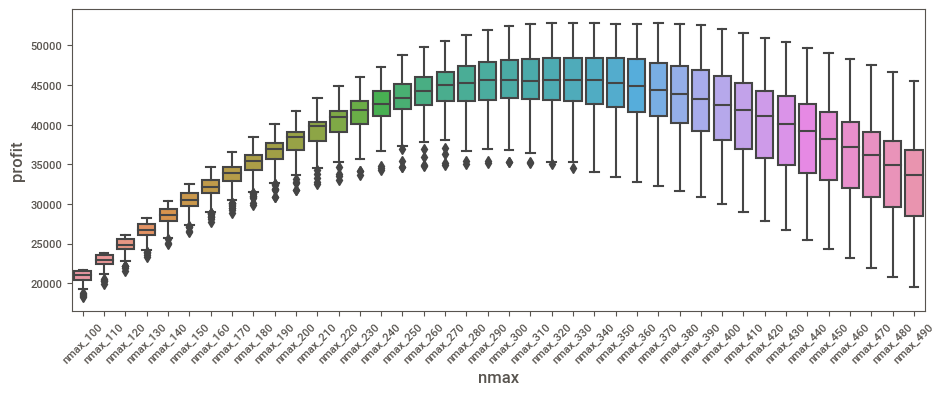

In [72]:
ax = sns.boxplot(x="nmax", y="profit", data=sim_profit_melted)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.show()

Let's also see how revenue, cost, and profit are interplaying. For that we will take a median of simulations.

The above plot does not give an idea about how profit variation is changing with nmax because with increaseing nmax profit scale is also increasing. To solve this problem we will calculate Relative Standard Deviation (RSD) or Coeffiient of Variation (The difference being that coefficient of variation divides by the mean rather than the absolute value of the mean), as it is formally called, and will plot it along nmax.

In [73]:
sim_profit_mean_array = np.apply_along_axis(lambda x: np.abs(np.mean(x)), 1, sim_array_profit)
sim_profit_std_array = np.apply_along_axis(np.std, 1, sim_array_profit)
sim_profit_rsd = sim_profit_std_array/sim_profit_mean_array

sim_profit_rsd_df = pd.DataFrame(data=sim_profit_rsd, index=nmax_array, columns=['rsd'])
sim_profit_rsd_df.index.name = 'nmax'
sim_profit_rsd_df.reset_index(inplace=True)

px.line(sim_profit_rsd_df, x='nmax', y='rsd')

So, coeffiient of variation increases steeply with nmax i.e. uncertainity of the profit predictions increases with increasing nmax. But, **demand prediction does not depend on max and this uncertainity is coming from there, which means the source of the increasing uncertainity is the increasing scale, somehow it is not getting normalized by the mean**. Would have liked to explore this further but will leave it here because of time constraints

In [74]:
sim_median_array = np.apply_along_axis(np.median, 1, sim_array)

sim_median_array_df = pd.DataFrame(data = sim_median_array, columns=['revenue', 'cost', 'profit'], index=nmax_array)
sim_median_array_df.index.name = 'nmax'
sim_median_array_df.reset_index(inplace=True)

px.line(sim_median_array_df, x='nmax', y=['revenue', 'cost', 'profit'])

In [75]:
sim_array_profit_median = np.apply_along_axis(np.median, 1, sim_array_profit)
max_profit_median = np.max(sim_array_profit_median)
nmax_for_max_profit_median = nmax_array[np.argmax(sim_array_profit_median)]
print('max median profit of ', max_profit_median, ' at nmax: ', nmax_for_max_profit_median)

max median profit of  45666.01114760221  at nmax:  330


## Part 6 - Reflection / comments

### Mistakes/To-be-Improved

- 30 days of data is actually 31 days of data :). I just took the last month, and then it was too much effort to make it 30 and rename part of variable names from 30 to 31
- Code Quality: 
    - Repetition of functionality, e.g. get_eval_metric() calculates error, but then I calculate them again for model comparison
    - Can be ore modular
    - Hard coding variable names, for e.g. 'abs_error_train_rf1'
    - Pipelines (like those in sklearn) not used
    - Not dividing space judiciously for plotting

### Would have done if had more time

- Revisit evaluation metric and try to answer "do we want a forecast which is little off at many places, or one which is more off at fewer places?" from business point of view using optimization visualizations
- Figure out why test predictions are so off?
    - I suspect its a time effect, so making trend, lag, and moving averages features could have helped. Though they are somehow getting captured in time based features like year, season, etc., but not completely supposedly
    - Model 'casual' and 'registered' separately. Am sure this will improve the predictions, all the EDA hints towards this
- Figure out why RSD is increasing with nmax

## Submission

Please submit this notebook with your developments in .ipynb and .html formats as well as your requirements.txt file.

## References

[1] Lichman, M. (2013). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science. 